In [1]:
from extract import MysqlLoader
from model import MaPredictor, ExpPredictor
from joblib import dump
from config import MODEL_PATH

In [2]:
df = MysqlLoader("select * from brent").load()

def train_model(df):
    print("Training Start.")
    model = MaPredictor(10)
    model.fit(df)
    print("Training completed.")
    return model
    

/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [3]:
model = train_model(df)

# save model
dump(model, open(MODEL_PATH,'wb'))
print(f"Model saved to {MODEL_PATH}")

Training Start.
Training completed.
Model saved to ./models/ma10.joblib


#### Code to evaluate the model

In [4]:
MysqlLoader("select * from brent_predict").load().columns

/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %',
       'prediction'],
      dtype='object')

In [5]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2022-05-24,110.13,110.21,110.52,109.70,-,-0.59%
1,2022-05-23,110.78,110.29,111.59,109.30,191.99K,0.54%
2,2022-05-22,110.18,110.19,110.30,109.38,-,-2.11%
3,2022-05-20,112.55,111.45,113.23,110.52,180.89K,0.46%
4,2022-05-19,112.04,108.22,112.31,105.70,272.35K,2.69%
...,...,...,...,...,...,...,...
2681,2012-01-09,112.45,113.42,113.88,111.80,203.39K,-0.54%
2682,2012-01-06,113.06,112.85,113.68,112.03,190.83K,0.28%
2683,2012-01-05,112.74,113.50,114.64,112.10,205.41K,-0.84%
2684,2012-01-04,113.70,112.10,113.97,111.27,221.27K,1.40%


In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(
    df[["Price"]],
    trend = 'add',           # or "mul" rarely used
    seasonal = 'add',        # or "mul"
    seasonal_periods = 12
)

result = model.fit()

preds = model.predict(params=result.params, start=0, end=len(df) + 19)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [7]:
dump(result, open("./models/exp.joblib",'wb'))

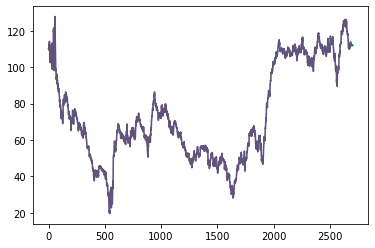

In [8]:
import matplotlib.pyplot as plt
plt.plot(preds)
plt.plot(df['Price'],color = 'red', alpha = 0.3)

In [9]:
from datetime import datetime, timedelta
import pandas as pd
prediction_df = pd.DataFrame(
    [df['Date'].iloc[-1] + timedelta(days = n) for n in range(1,21)],
    columns = ['Date'])

In [10]:
pred_df = pd.concat([df, prediction_df])
pred_df['prediction'] = preds

In [11]:
pred_df

,Date,Price,Open,High,Low,Vol.,Change %,prediction
0,2022-05-24,110.13,110.21,110.52,109.70,-,-0.59%,110.153512
1,2022-05-23,110.78,110.29,111.59,109.30,191.99K,0.54%,109.887324
2,2022-05-22,110.18,110.19,110.30,109.38,-,-2.11%,110.654700
3,2022-05-20,112.55,111.45,113.23,110.52,180.89K,0.46%,110.082611
4,2022-05-19,112.04,108.22,112.31,105.70,272.35K,2.69%,112.639987
...,...,...,...,...,...,...,...,...
15,2012-01-19,NaN,NaN,NaN,NaN,NaN,NaN,111.929827
16,2012-01-20,NaN,NaN,NaN,NaN,NaN,NaN,111.827916
17,2012-01-21,NaN,NaN,NaN,NaN,NaN,NaN,111.718090
18,2012-01-22,NaN,NaN,NaN,NaN,NaN,NaN,111.872726


In [13]:
# ExpPredictor(20).predict(df)